### Cab-Driver Agent

In [1]:
# Importing libraries
import numpy as np
import random
import math
from collections import deque
import collections
import pickle
import time

# for building DQN model
from keras import layers
from keras import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam

# for plotting graphs
import matplotlib.pyplot as plt

# Import the environment
from Env import CabDriver

Using TensorFlow backend.


#### Defining Time Matrix

In [2]:
Time_matrix = np.load("TM.npy")                                                # Loading the time matrix provided
env = CabDriver()                                                              # Environmnt Class

#### Tracking the state-action pairs for checking convergence


In [3]:
states_tracked = [[],[],[]] 
track_state = np.zeros((3, 36))                                                #Track 3 states (m,t,d) (0,0,0), (1,7,1), (3,7,4)
track_state[0] = env.state_encod_arch1([0,0,0])
track_state[1] = env.state_encod_arch1([1,7,1])
track_state[2] = env.state_encod_arch1([3,17,4])

#for above 3 states we will track 3 actions 1 action per state  
#1 -> (0,1) , 5 -> (1,0), (4,3)
track_action_index = [1,5,20]                                                  

In [4]:
#Defining a function to save the Q-dictionary as a pickle file
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

### Agent Class

If you are using this framework, you need to fill the following to complete the following code block:
1. State and Action Size
2. Hyperparameters
3. Create a neural-network model in function 'build_model()'
4. Define epsilon-greedy strategy in function 'get_action()'
5. Complete the function 'append_sample()'. This function appends the recent experience tuple <state, action, reward, new-state> to the memory
6. Complete the 'train_model()' function with following logic:
   - If the memory size is greater than mini-batch size, you randomly sample experiences from memory as per the mini-batch size and do the following:
      - Initialise your input and output batch for training the model
      - Calculate the target Q value for each sample: reward + gamma*max(Q(s'a,))
      - Get Q(s', a) values from the last trained model
      - Update the input batch as your encoded state and output batch as your Q-values
      - Then fit your DQN model using the updated input and output batch.

In [5]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        # Define size of state and action
        self.state_size = state_size
        self.action_size = action_size

        # Write here: Specify you hyper parameters for the DQN
        self.discount_factor = 0.95
        self.learning_rate =  0.01      
        self.epsilon_max = 1
        self.epsilon = 1
        self.epsilon_decay = -0.00015 
        self.epsilon_min = 0.00001
        
        self.batch_size = 32        
        # create replay memory using deque
        self.memory = deque(maxlen=2000)

        # create main model and target model
        self.model = self.build_model()

    # approximate Q function using Neural Network
    def build_model(self):
        
        model = Sequential()       
        model.add(Dense(32, input_dim=self.state_size, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(self.action_size, activation='relu', kernel_initializer='he_uniform'))
        model.compile(loss='mse',optimizer=Adam(lr=self.learning_rate))
        model.summary
        return model



    def get_action(self, state, possible_actions_index, actions):
        if np.random.rand() <= self.epsilon:
            return random.choice(possible_actions_index)    #choose the random action
        else:
            state = np.array(env.state_encod_arch1(state)).reshape(1, 36) #reshape to (1,36) 1 is batch size
            q_value = self.model.predict(state)
            q_vals_possible = [q_value[0][i] for i in possible_actions_index]
            return possible_actions_index[np.argmax(q_vals_possible)]      
        
        
    def append_sample(self, state, action, reward, next_state):
        self.memory.append((state, action, reward, next_state))
    
    
    
    # pick samples randomly from replay memory (with batch_size) and train the network
    def train_model(self):
        
        if len(self.memory) > self.batch_size:
            mini_batch = random.sample(self.memory, self.batch_size)               #Fetch batch from memory
            update_input = np.zeros((self.batch_size, self.state_size))            #initialize the input 
            update_output = np.zeros((self.batch_size, self.state_size))           #initialize the input 
            
            actions, rewards = [], []
            
            for i in range(self.batch_size):
                state, action, reward, next_state  = mini_batch[i]
                update_input[i] = env.state_encod_arch1(state)     
                actions.append(action)
                rewards.append(reward)
                update_output[i] = env.state_encod_arch1(next_state)
                
            
            target = self.model.predict(update_input)                               #predict the target q-values
            target_qval = self.model.predict(update_output)                         #predict target for q-network
                
            for i in range(self.batch_size):                                        #update rewards 
                  target[i][actions[i]] = rewards[i] + self.discount_factor * np.max(target_qval[i])    
                
                
            self.model.fit(update_input, target, batch_size=self.batch_size, epochs=1, verbose=0) 
    
    def save_tracking_states(self):
        q_value = self.model.predict(track_state)
        states_tracked[0].append(q_value[0][track_action_index[0]])
        states_tracked[1].append(q_value[1][track_action_index[1]])
        states_tracked[2].append(q_value[2][track_action_index[2]])

    def save(self, name):
        self.model.save(name)

In [6]:
Episodes = 20000
max_episode_hours = 24*30 

action_space, state_space, init_state = env.reset()
env_hyper_pars = env.get_hyper_params()
state_size = env_hyper_pars[0] + env_hyper_pars[1] + env_hyper_pars[2]         # number of cities + number of hours+ number of days
action_size = len(action_space)                                                # len of action space

agent = DQNAgent(action_size=action_size, state_size=state_size)               # invoke Agent 


rewards_per_episode, episodes = [], []
rewards_init_state = []
start_time = time.time()
score_tracked = []
epsilon_global = []

### DQN block

In [7]:
for episode in range(Episodes):

    terminal_state = False
    score = 0
    env = CabDriver()                                                   #Initialize the environment for each episode
    action_space, state_space, state_init = env.reset()     

    total_time = 0                                                      # Track total episode time.
    state = state_init
    
    while not terminal_state:
        possible_actions_indices, actions = env.requests(state)
        action = agent.get_action(state, possible_actions_indices, actions)
        reward, next_state, step_time = env.step(state, env.action_space[action], Time_matrix)
        total_time += step_time
        if (total_time > max_episode_hours):
            terminal_state = True
        else:
            agent.append_sample(state, action, reward, next_state)
            agent.train_model()
            score += reward
            state = next_state
    
    
    rewards_per_episode.append(score)
    episodes.append(episode)
    epsilon_global.append(agent.epsilon)
    agent.epsilon = (1 - 0.00001) * np.exp(agent.epsilon_decay * episode)   # epsilon decay


    if ((episode + 1) % 20 == 0):                                           # print every 20 episodes:
        print("episode {0}, reward {1}, memory_length {2}, epsilon {3} total_time {4}".format(episode,
                                                                         score,
                                                                         len(agent.memory),
                                                                         agent.epsilon, total_time))
    
    if ((episode + 1) % 5 == 0):                                 # Save the Q_value of the state, action pair we are tracking           
        agent.save_tracking_states()

    score_tracked.append(score)                                  # Total rewards per episode

    if(episode % 1000 == 0):
        print("Saving Model {}".format(episode))
        agent.save(name="model_weights.pkl")
    
elapsed_time = time.time() - start_time
print(elapsed_time)
        

Saving Model 0
episode 19, reward -441.0, memory_length 2000, epsilon 0.997144085853986 total_time 724.0
episode 39, reward 60.0, memory_length 2000, epsilon 0.9941571362610253 total_time 725.0
episode 59, reward 252.0, memory_length 2000, epsilon 0.9911791340890016 total_time 721.0
episode 79, reward -206.0, memory_length 2000, epsilon 0.9882100525358751 total_time 731.0
episode 99, reward -236.0, memory_length 2000, epsilon 0.985249864879892 total_time 721.0
episode 119, reward -323.0, memory_length 2000, epsilon 0.982298544479343 total_time 727.0
episode 139, reward -526.0, memory_length 2000, epsilon 0.979356064772325 total_time 731.0
episode 159, reward 94.0, memory_length 2000, epsilon 0.9764223992765005 total_time 723.0
episode 179, reward -247.0, memory_length 2000, epsilon 0.9734975215888604 total_time 730.0
episode 199, reward -9.0, memory_length 2000, epsilon 0.9705814053854857 total_time 724.0
episode 219, reward -252.0, memory_length 2000, epsilon 0.9676740244213108 total_

episode 1819, reward 303.0, memory_length 2000, epsilon 0.7611993480401995 total_time 723.0
episode 1839, reward 392.0, memory_length 2000, epsilon 0.7589191719703156 total_time 729.0
episode 1859, reward 14.0, memory_length 2000, epsilon 0.756645826178102 total_time 727.0
episode 1879, reward 155.0, memory_length 2000, epsilon 0.7543792902034314 total_time 725.0
episode 1899, reward 84.0, memory_length 2000, epsilon 0.7521195436474647 total_time 721.0
episode 1919, reward 343.0, memory_length 2000, epsilon 0.7498665661724677 total_time 724.0
episode 1939, reward 535.0, memory_length 2000, epsilon 0.7476203375016278 total_time 726.0
episode 1959, reward 437.0, memory_length 2000, epsilon 0.7453808374188718 total_time 725.0
episode 1979, reward 464.0, memory_length 2000, epsilon 0.7431480457686841 total_time 722.0
episode 1999, reward 631.0, memory_length 2000, epsilon 0.7409219424559244 total_time 727.0
Saving Model 2000
episode 2019, reward 412.0, memory_length 2000, epsilon 0.7387025

episode 3599, reward 486.0, memory_length 2000, epsilon 0.5828298428113797 total_time 721.0
episode 3619, reward 920.0, memory_length 2000, epsilon 0.5810839733964699 total_time 722.0
episode 3639, reward 636.0, memory_length 2000, epsilon 0.5793433337412429 total_time 729.0
episode 3659, reward 456.0, memory_length 2000, epsilon 0.57760790817993 total_time 724.0
episode 3679, reward 1085.0, memory_length 2000, epsilon 0.5758776810936898 total_time 728.0
episode 3699, reward 916.0, memory_length 2000, epsilon 0.5741526369104664 total_time 723.0
episode 3719, reward 683.0, memory_length 2000, epsilon 0.5724327601048509 total_time 722.0
episode 3739, reward 577.0, memory_length 2000, epsilon 0.5707180351979402 total_time 725.0
episode 3759, reward 642.0, memory_length 2000, epsilon 0.5690084467571986 total_time 725.0
episode 3779, reward 620.0, memory_length 2000, epsilon 0.5673039793963187 total_time 722.0
episode 3799, reward 699.0, memory_length 2000, epsilon 0.5656046177750826 total_

episode 5379, reward 606.0, memory_length 2000, epsilon 0.44625711588707023 total_time 722.0
episode 5399, reward 797.0, memory_length 2000, epsilon 0.4449203506897787 total_time 730.0
episode 5419, reward 1221.0, memory_length 2000, epsilon 0.44358758977864665 total_time 728.0
episode 5439, reward 1107.0, memory_length 2000, epsilon 0.44225882115881676 total_time 729.0
episode 5459, reward 952.0, memory_length 2000, epsilon 0.4409340328713625 total_time 721.0
episode 5479, reward 851.0, memory_length 2000, epsilon 0.4396132129931805 total_time 729.0
episode 5499, reward 968.0, memory_length 2000, epsilon 0.43829634963688274 total_time 724.0
episode 5519, reward 956.0, memory_length 2000, epsilon 0.43698343095069025 total_time 728.0
episode 5539, reward 1054.0, memory_length 2000, epsilon 0.435674445118326 total_time 734.0
episode 5559, reward 972.0, memory_length 2000, epsilon 0.43436938035890854 total_time 721.0
episode 5579, reward 970.0, memory_length 2000, epsilon 0.43306822492684

episode 7139, reward 1253.0, memory_length 2000, epsilon 0.3427136568847863 total_time 725.0
episode 7159, reward 1567.0, memory_length 2000, epsilon 0.3416870565845324 total_time 726.0
episode 7179, reward 1259.0, memory_length 2000, epsilon 0.3406635314700942 total_time 723.0
episode 7199, reward 1166.0, memory_length 2000, epsilon 0.33964307232973867 total_time 721.0
episode 7219, reward 1086.0, memory_length 2000, epsilon 0.33862566997932675 total_time 722.0
episode 7239, reward 1008.0, memory_length 2000, epsilon 0.33761131526223026 total_time 726.0
episode 7259, reward 1401.0, memory_length 2000, epsilon 0.33659999904925014 total_time 728.0
episode 7279, reward 1247.0, memory_length 2000, epsilon 0.33559171223853346 total_time 730.0
episode 7299, reward 952.0, memory_length 2000, epsilon 0.3345864457554922 total_time 727.0
episode 7319, reward 1224.0, memory_length 2000, epsilon 0.33358419055272115 total_time 724.0
episode 7339, reward 1338.0, memory_length 2000, epsilon 0.332584

episode 8899, reward 1476.0, memory_length 2000, epsilon 0.26319502016650326 total_time 723.0
episode 8919, reward 1505.0, memory_length 2000, epsilon 0.2624066183001046 total_time 725.0
episode 8939, reward 1008.0, memory_length 2000, epsilon 0.26162057809504197 total_time 726.0
episode 8959, reward 1266.0, memory_length 2000, epsilon 0.2608368924769481 total_time 723.0
episode 8979, reward 1076.0, memory_length 2000, epsilon 0.2600555543926472 total_time 721.0
episode 8999, reward 1640.0, memory_length 2000, epsilon 0.2592765568100912 total_time 725.0
Saving Model 9000
episode 9019, reward 1077.0, memory_length 2000, epsilon 0.2584998927182966 total_time 728.0
episode 9039, reward 1712.0, memory_length 2000, epsilon 0.25772555512728135 total_time 726.0
episode 9059, reward 1374.0, memory_length 2000, epsilon 0.2569535370680019 total_time 727.0
episode 9079, reward 1496.0, memory_length 2000, epsilon 0.25618383159229047 total_time 725.0
episode 9099, reward 1164.0, memory_length 2000,

episode 10639, reward 1586.0, memory_length 2000, epsilon 0.20273410217196344 total_time 721.0
episode 10659, reward 1663.0, memory_length 2000, epsilon 0.20212681125728765 total_time 726.0
episode 10679, reward 1571.0, memory_length 2000, epsilon 0.2015213394852776 total_time 728.0
episode 10699, reward 1596.0, memory_length 2000, epsilon 0.20091768140668312 total_time 723.0
episode 10719, reward 1413.0, memory_length 2000, epsilon 0.20031583158857752 total_time 721.0
episode 10739, reward 1687.0, memory_length 2000, epsilon 0.19971578461430836 total_time 727.0
episode 10759, reward 1553.0, memory_length 2000, epsilon 0.1991175350834488 total_time 727.0
episode 10779, reward 1279.0, memory_length 2000, epsilon 0.19852107761174903 total_time 727.0
episode 10799, reward 1432.0, memory_length 2000, epsilon 0.1979264068310878 total_time 724.0
episode 10819, reward 1058.0, memory_length 2000, epsilon 0.19733351738942403 total_time 725.0
episode 10839, reward 1526.0, memory_length 2000, eps

episode 12379, reward 1580.0, memory_length 2000, epsilon 0.1561622106583574 total_time 730.0
episode 12399, reward 1877.0, memory_length 2000, epsilon 0.15569442605412706 total_time 728.0
episode 12419, reward 1423.0, memory_length 2000, epsilon 0.15522804270078217 total_time 729.0
episode 12439, reward 1500.0, memory_length 2000, epsilon 0.15476305640086938 total_time 725.0
episode 12459, reward 1395.0, memory_length 2000, epsilon 0.1542994629695088 total_time 729.0
episode 12479, reward 1564.0, memory_length 2000, epsilon 0.15383725823435654 total_time 725.0
episode 12499, reward 1729.0, memory_length 2000, epsilon 0.15337643803556672 total_time 726.0
episode 12519, reward 1667.0, memory_length 2000, epsilon 0.15291699822575455 total_time 725.0
episode 12539, reward 1388.0, memory_length 2000, epsilon 0.15245893466995858 total_time 727.0
episode 12559, reward 1520.0, memory_length 2000, epsilon 0.15200224324560377 total_time 722.0
episode 12579, reward 1697.0, memory_length 2000, ep

episode 14119, reward 1324.0, memory_length 2000, epsilon 0.12028877123504325 total_time 727.0
episode 14139, reward 1555.0, memory_length 2000, epsilon 0.11992844567991492 total_time 721.0
episode 14159, reward 1631.0, memory_length 2000, epsilon 0.11956919948160724 total_time 725.0
episode 14179, reward 1525.0, memory_length 2000, epsilon 0.11921102940690202 total_time 721.0
episode 14199, reward 1635.0, memory_length 2000, epsilon 0.1188539322322661 total_time 723.0
episode 14219, reward 1405.0, memory_length 2000, epsilon 0.11849790474382253 total_time 727.0
episode 14239, reward 1553.0, memory_length 2000, epsilon 0.11814294373732152 total_time 730.0
episode 14259, reward 1270.0, memory_length 2000, epsilon 0.11778904601811165 total_time 727.0
episode 14279, reward 1603.0, memory_length 2000, epsilon 0.11743620840111099 total_time 727.0
episode 14299, reward 1764.0, memory_length 2000, epsilon 0.11708442771077861 total_time 721.0
episode 14319, reward 1518.0, memory_length 2000, e

episode 15859, reward 1491.0, memory_length 2000, epsilon 0.09265614532629697 total_time 723.0
episode 15879, reward 1620.0, memory_length 2000, epsilon 0.09237859342633196 total_time 729.0
episode 15899, reward 1403.0, memory_length 2000, epsilon 0.0921018729343313 total_time 724.0
episode 15919, reward 1336.0, memory_length 2000, epsilon 0.09182598135980873 total_time 723.0
episode 15939, reward 1300.0, memory_length 2000, epsilon 0.09155091621973821 total_time 721.0
episode 15959, reward 1377.0, memory_length 2000, epsilon 0.0912766750385317 total_time 726.0
episode 15979, reward 1508.0, memory_length 2000, epsilon 0.09100325534801659 total_time 722.0
episode 15999, reward 1764.0, memory_length 2000, epsilon 0.09073065468741391 total_time 726.0
Saving Model 16000
episode 16019, reward 1485.0, memory_length 2000, epsilon 0.09045887060331584 total_time 728.0
episode 16039, reward 1774.0, memory_length 2000, epsilon 0.09018790064966384 total_time 726.0
episode 16059, reward 1368.0, mem

episode 17579, reward 1663.0, memory_length 2000, epsilon 0.07158569610450367 total_time 724.0
episode 17599, reward 1486.0, memory_length 2000, epsilon 0.07137126082992848 total_time 723.0
episode 17619, reward 1756.0, memory_length 2000, epsilon 0.07115746789718247 total_time 724.0
episode 17639, reward 1519.0, memory_length 2000, epsilon 0.07094431538212786 total_time 722.0
episode 17659, reward 1451.0, memory_length 2000, epsilon 0.07073180136639057 total_time 722.0
episode 17679, reward 1523.0, memory_length 2000, epsilon 0.07051992393734305 total_time 722.0
episode 17699, reward 1652.0, memory_length 2000, epsilon 0.07030868118808693 total_time 724.0
episode 17719, reward 1556.0, memory_length 2000, epsilon 0.0700980712174361 total_time 722.0
episode 17739, reward 1285.0, memory_length 2000, epsilon 0.06988809212989938 total_time 723.0
episode 17759, reward 1640.0, memory_length 2000, epsilon 0.0696787420356636 total_time 726.0
episode 17779, reward 1517.0, memory_length 2000, ep

episode 19299, reward 1785.0, memory_length 2000, epsilon 0.05530676749739503 total_time 721.0
episode 19319, reward 1665.0, memory_length 2000, epsilon 0.0551410958266627 total_time 728.0
episode 19339, reward 1351.0, memory_length 2000, epsilon 0.054975920426164976 total_time 728.0
episode 19359, reward 1480.0, memory_length 2000, epsilon 0.05481123980932218 total_time 726.0
episode 19379, reward 1689.0, memory_length 2000, epsilon 0.054647052494007656 total_time 723.0
episode 19399, reward 1733.0, memory_length 2000, epsilon 0.054483357002534455 total_time 730.0
episode 19419, reward 1766.0, memory_length 2000, epsilon 0.054320151861642026 total_time 721.0
episode 19439, reward 1755.0, memory_length 2000, epsilon 0.054157435602483005 total_time 721.0
episode 19459, reward 1621.0, memory_length 2000, epsilon 0.053995206760609975 total_time 727.0
episode 19479, reward 1922.0, memory_length 2000, epsilon 0.05383346387596228 total_time 721.0
episode 19499, reward 1576.0, memory_length 2

In [8]:
states_tracked

[[212.1192,
  216.19539,
  210.31212,
  354.96487,
  459.28915,
  442.98447,
  435.32043,
  449.39658,
  456.25592,
  524.88995,
  501.83044,
  854.49316,
  652.22766,
  469.82602,
  562.9873,
  571.20306,
  707.42395,
  521.7409,
  544.97534,
  461.36017,
  476.22842,
  414.59772,
  507.1462,
  497.62943,
  521.19653,
  537.8249,
  577.2056,
  546.59863,
  524.16473,
  535.3169,
  517.2242,
  582.87506,
  550.1134,
  599.66534,
  619.4908,
  571.3994,
  599.9216,
  605.0806,
  603.8635,
  586.2015,
  585.42554,
  568.6108,
  614.68933,
  518.2229,
  547.3276,
  583.1609,
  505.61218,
  505.38617,
  547.3834,
  616.88574,
  585.6773,
  583.74945,
  560.18054,
  526.6845,
  649.69836,
  648.8838,
  587.2346,
  528.37415,
  614.72723,
  621.1361,
  582.0027,
  598.2756,
  604.6298,
  554.377,
  612.51996,
  569.0441,
  595.6111,
  549.89795,
  578.9517,
  567.06256,
  619.98425,
  561.485,
  583.71655,
  570.93884,
  591.90906,
  586.7538,
  548.8097,
  579.64185,
  610.57104,
  547.7538

### Tracking Convergence

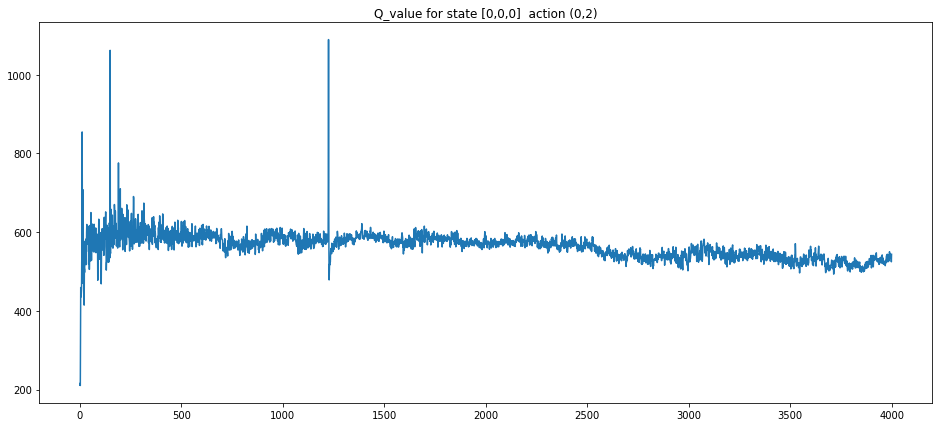

In [9]:
plt.figure(0, figsize=(16,7))
plt.title('Q_value for state [0,0,0]  action (0,1)')
xaxis = np.asarray(range(0, len(states_tracked[0])))
plt.plot(xaxis,np.asarray(states_tracked[0]))
plt.show()

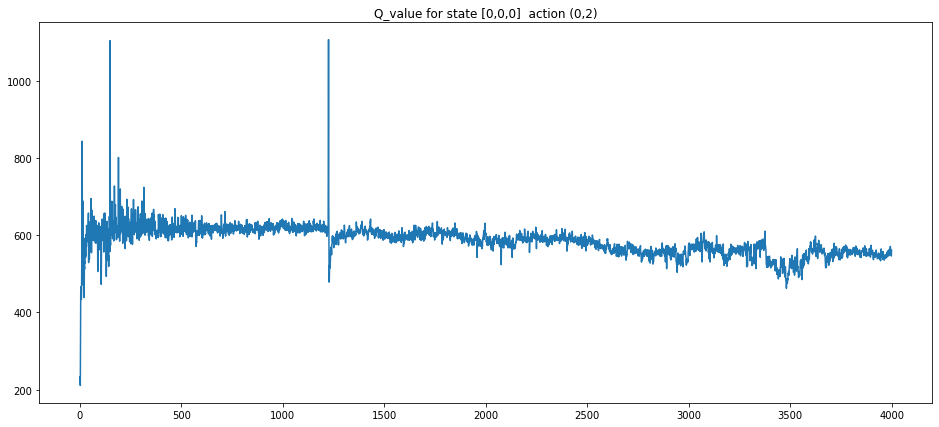

In [10]:
plt.figure(0, figsize=(16,7))
plt.title('Q_value for state [1,7,1]  action (1,0)')
xaxis = np.asarray(range(0, len(states_tracked[1])))
plt.plot(xaxis,np.asarray(states_tracked[1]))
plt.show()

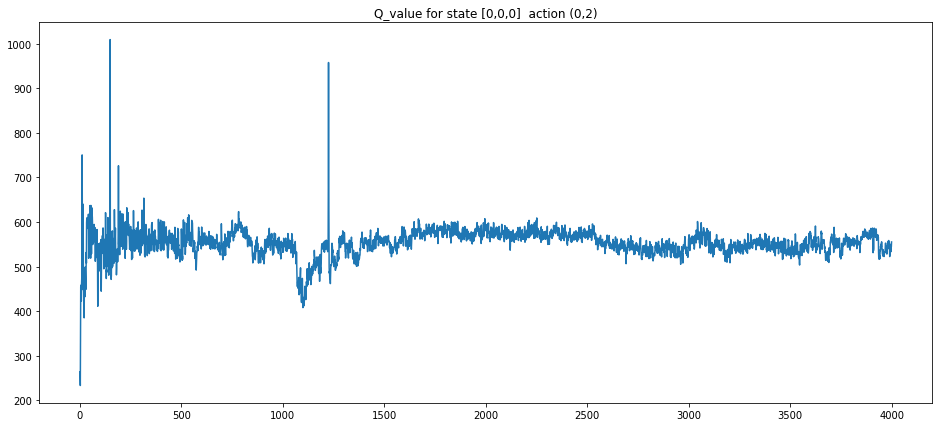

In [11]:
plt.figure(0, figsize=(16,7))
plt.title('Q_value for state [3,17,4]  action (4,3)')
xaxis = np.asarray(range(0, len(states_tracked[2])))
plt.plot(xaxis,np.asarray(states_tracked[2]))
plt.show()

For all the 3 state - action pair tracked, we are getting steady reward at around 600.

#### Epsilon-decay function

In [12]:
time = np.arange(0,20000)

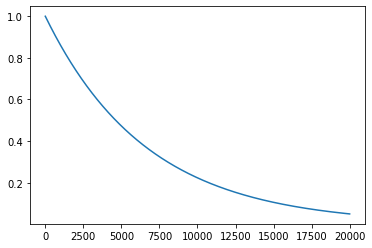

In [13]:
plt.plot(time, epsilon_global)
plt.show()